In [21]:
import pandas as pd
import glob
import pickle
from Bio.Seq import Seq
from matplotlib import cm
from matplotlib.colors import Normalize, to_hex

# DMS data

Single mutant scores

In [2]:
dms_df = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv")
dms_df

,target,wildtype,position,position_IMTG,chain,mutant,mutation,codon,single_nt,bind,...,n_bc_bind,n_libs_bind,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr
0,CGG_naive,E,1,1.0,H,A,E1(H)A,GAG,True,10.48829,...,15.0,2.0,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0
1,CGG_naive,E,1,1.0,H,C,E1(H)C,GAG,False,10.44477,...,19.0,2.0,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0
2,CGG_naive,E,1,1.0,H,D,E1(H)D,GAG,True,10.42771,...,13.0,2.0,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0
3,CGG_naive,E,1,1.0,H,E,E1(H)E,GAG,True,10.45719,...,17528.0,2.0,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0
4,CGG_naive,E,1,1.0,H,F,E1(H)F,GAG,False,10.51899,...,20.0,2.0,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,CGG_naive,NaN,121,NaN,link,S,NANA(link)S,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4736,CGG_naive,NaN,121,NaN,link,T,NANA(link)T,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4737,CGG_naive,NaN,121,NaN,link,V,NANA(link)V,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4738,CGG_naive,NaN,121,NaN,link,W,NANA(link)W,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Position maps for scFv

In [3]:
pos_df = pd.read_csv("../data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()))
pos_df

,site_scFv,amino_acid,chain,site,KI_codon
0,1,E,H,1,GAG
1,2,V,H,2,GTG
2,3,Q,H,3,CAG
3,4,L,H,4,CTT
4,5,Q,H,5,CAG
...,...,...,...,...,...
230,231,L,L,120,CTA
231,232,E,L,121,GAA
232,233,I,L,122,ATA
233,234,K,L,123,AAA


In [4]:
igh_pos_map = pos_df[pos_df.chain == "H"]
igk_pos_map = pos_df[pos_df.chain == "L"].reset_index(drop=True)

# Replay tree data

In [5]:
trees = [pickle.load(open(f, "rb")) for f in glob.glob("*/*/gctree.out.inference.1.p")]

In [14]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

## Function for color mapping $\Delta\log K_a$ on trees

- Cool colors indicate $\Delta\log K_a < 0$
- Warm colors indicate $\Delta\log K_a > 0$

In [90]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def bind_colormap(tree, vmin, vmax):
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    cmap = cm.get_cmap("coolwarm")
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    colormap = {}

    for node in tree.tree.traverse():
        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")

        sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()

        colormap[node.name] = to_hex(cmap(norm(sum_delta_bind)))

    return colormap

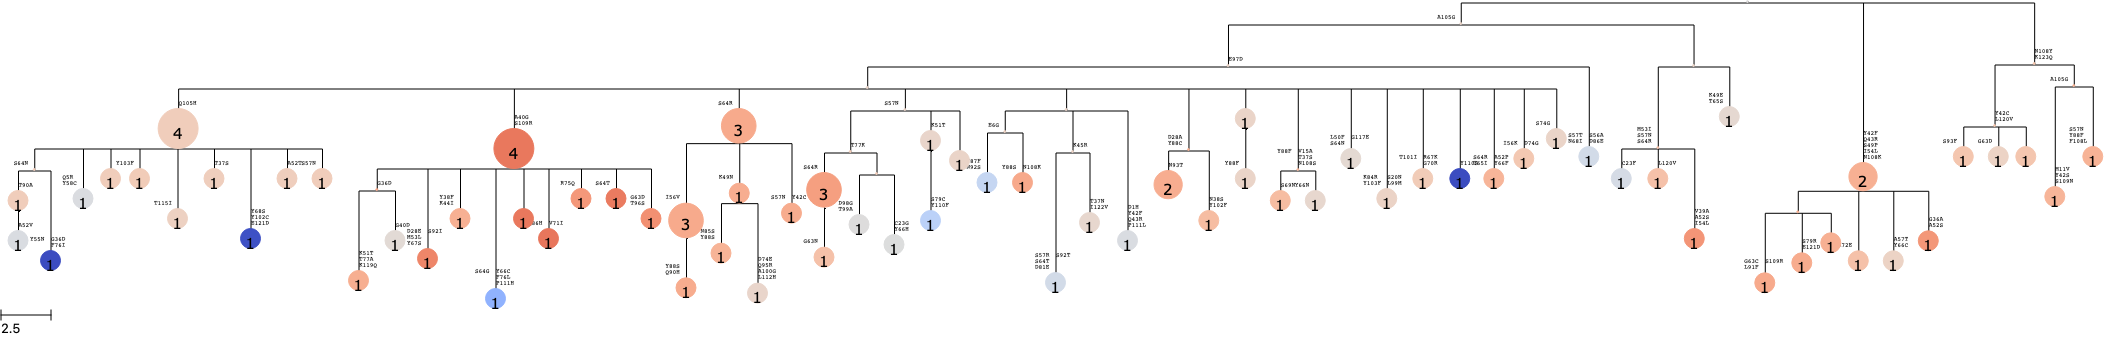

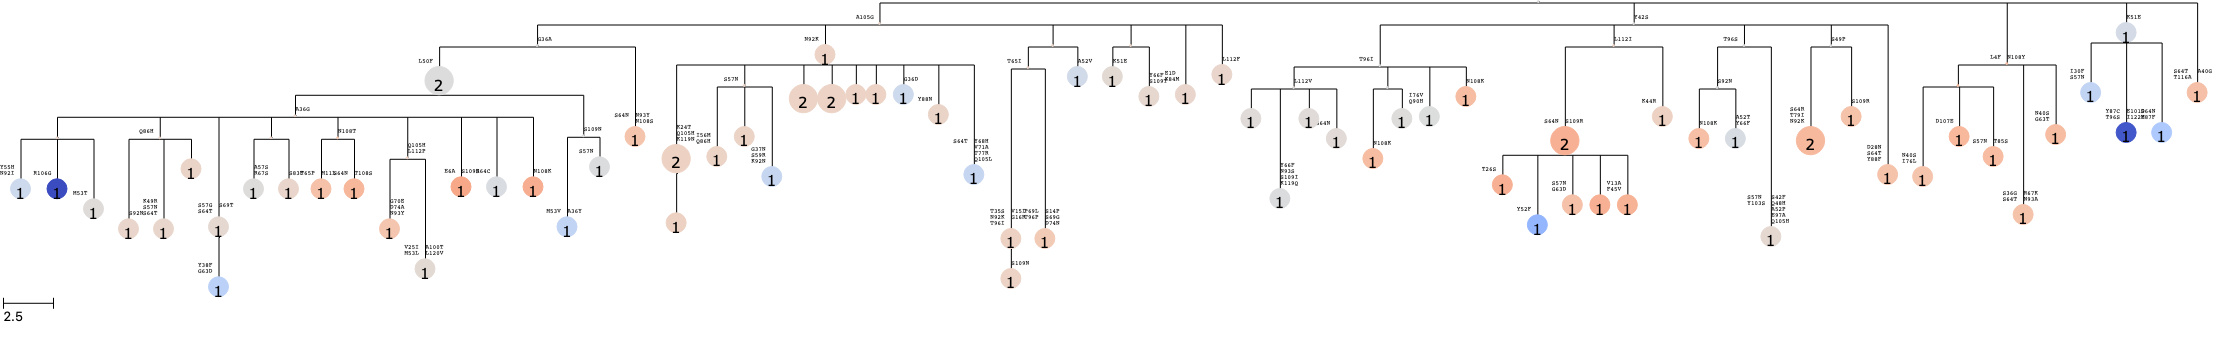

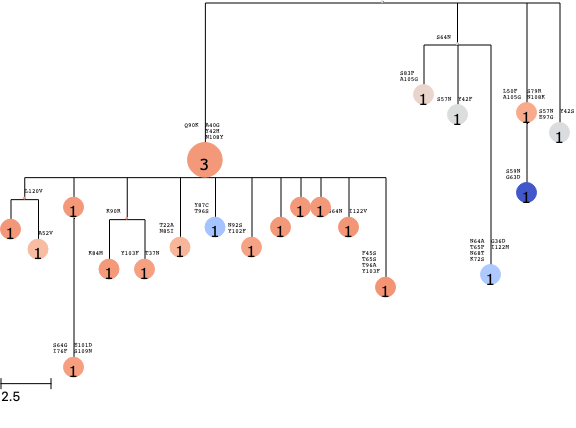

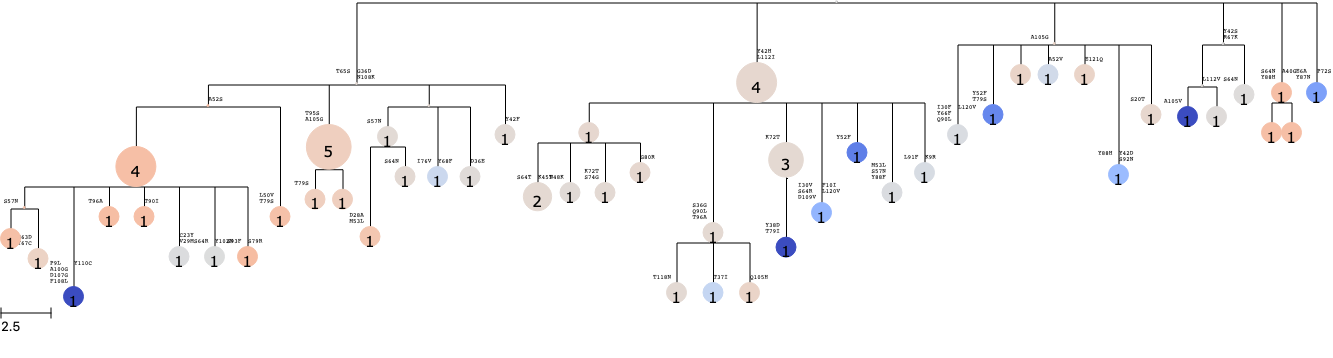

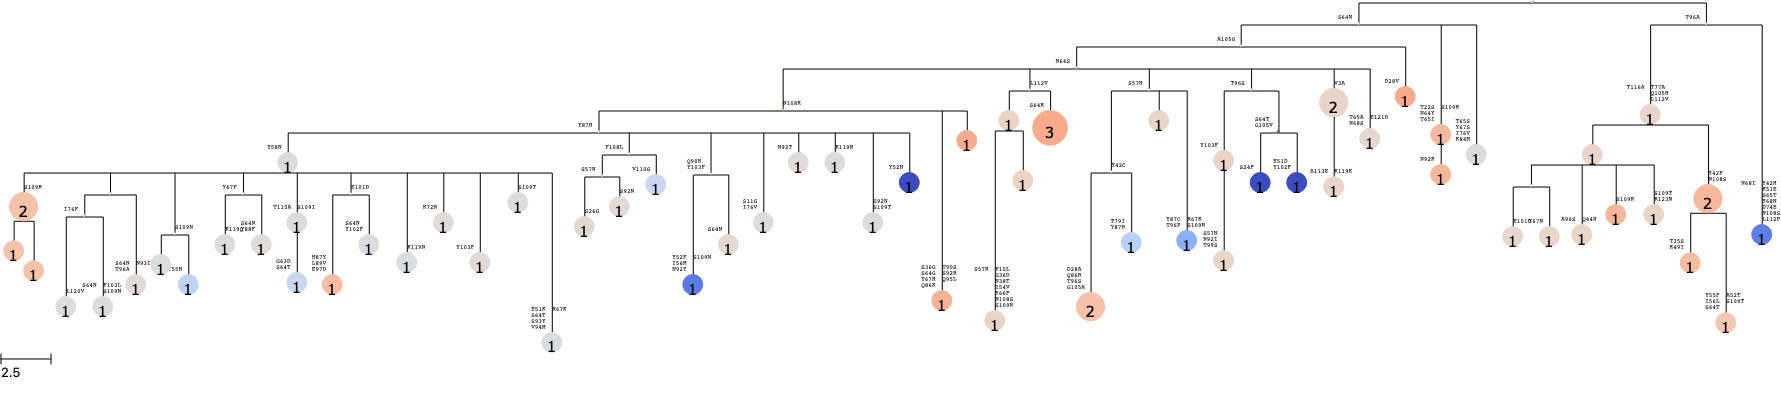

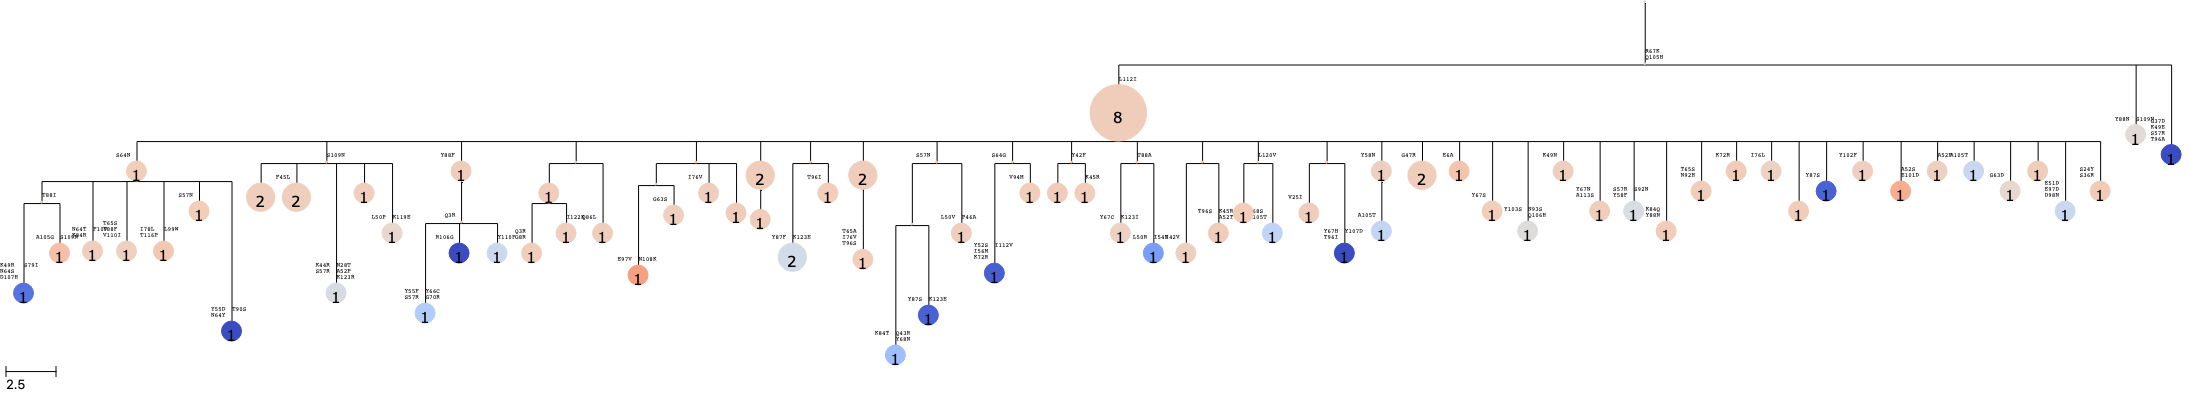

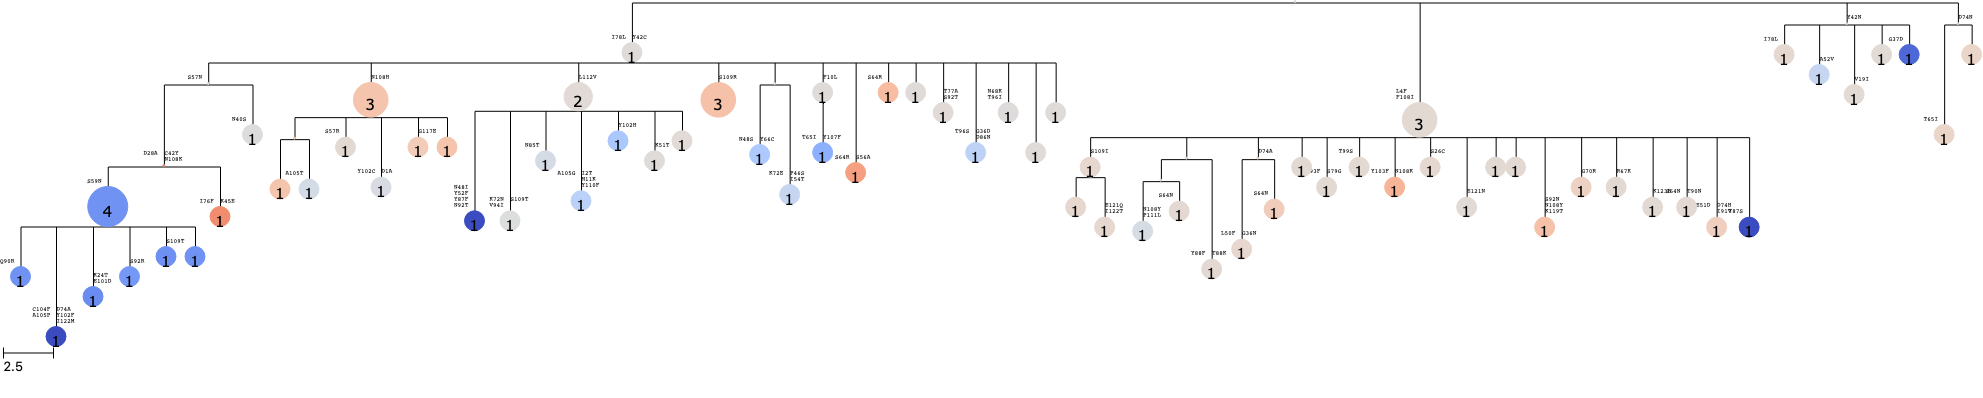

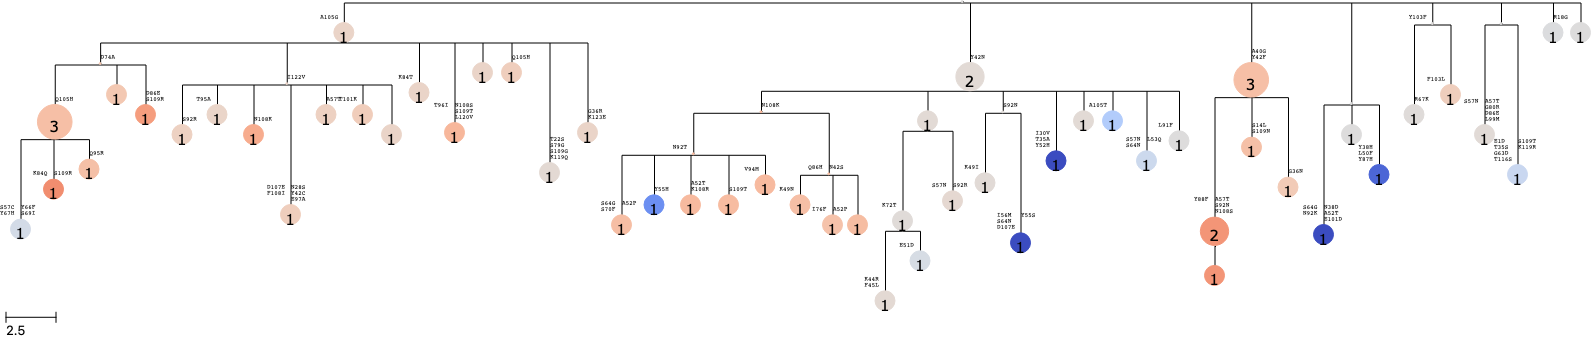

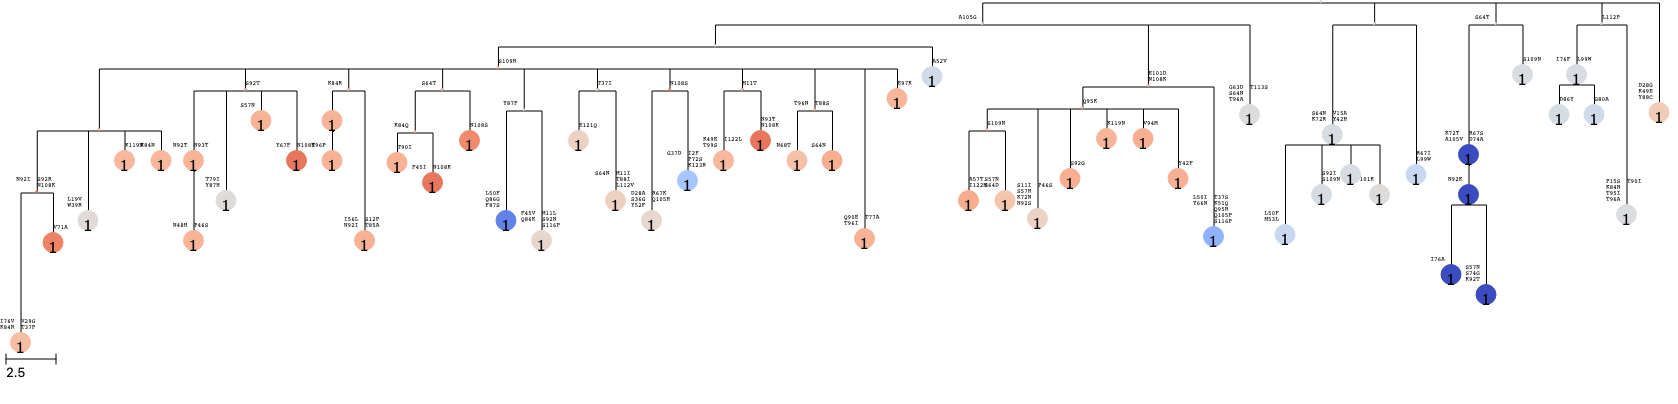

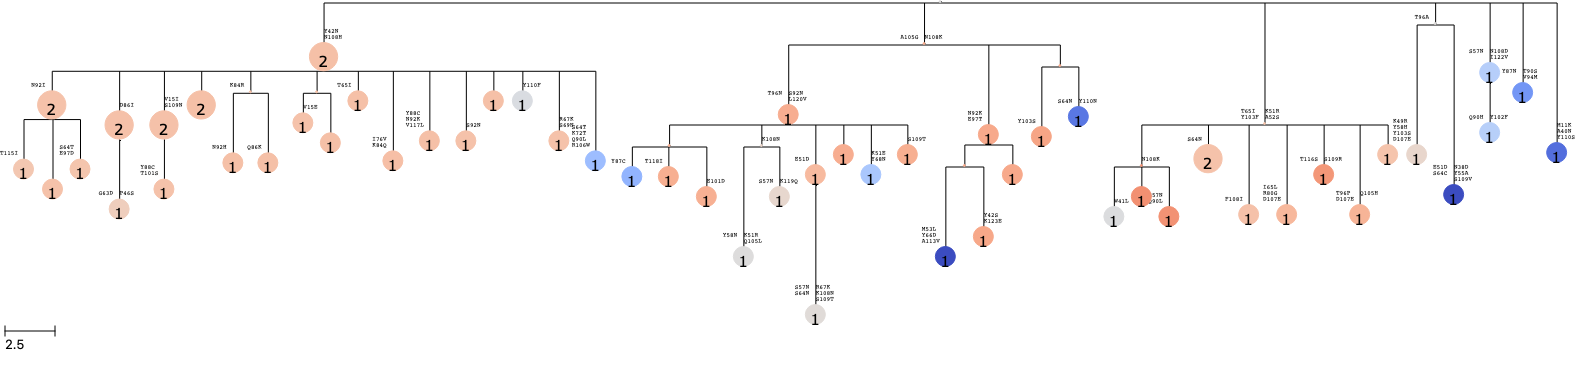

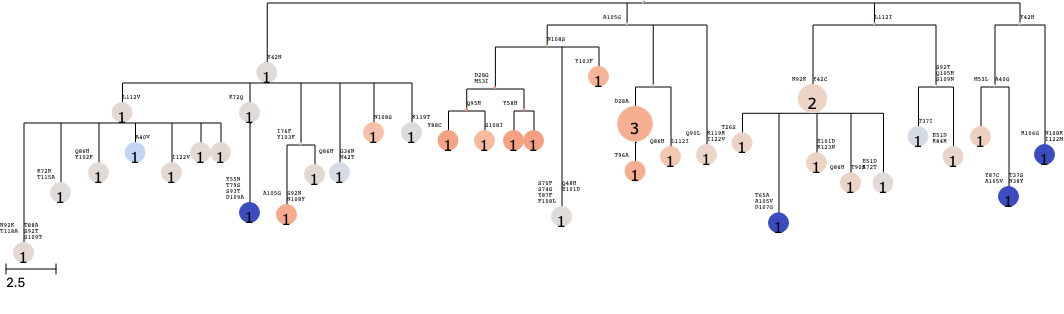

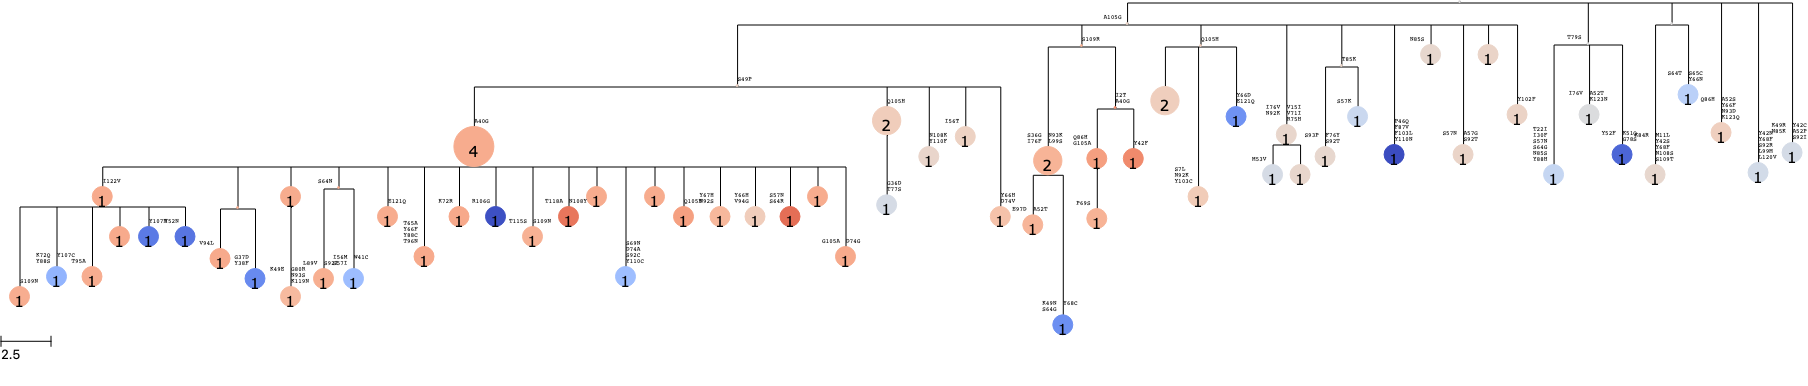

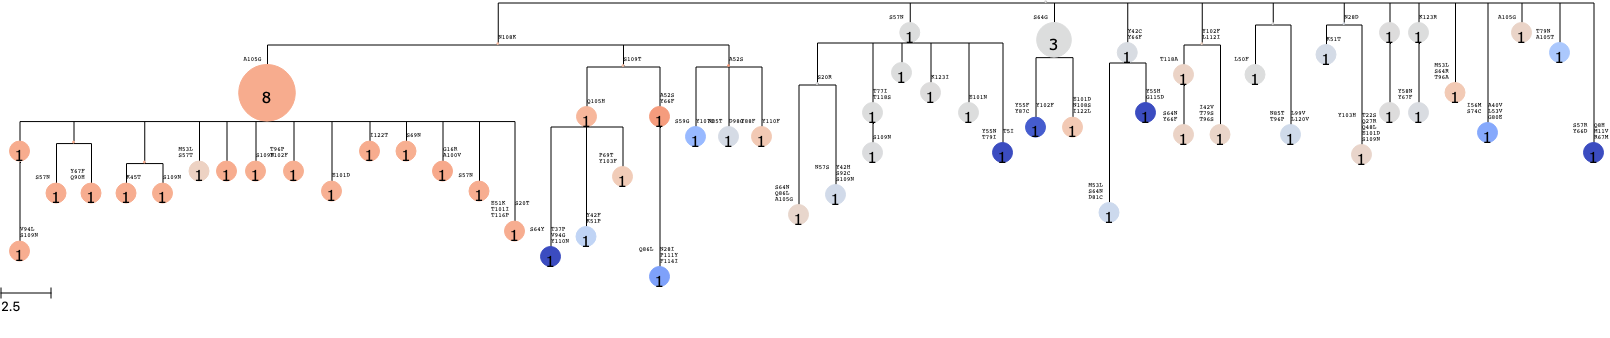

In [39]:
for tree in trees:
    display(tree.render("%%inline", scale=20,
                        colormap=bind_colormap(tree, -3, 3),
                        frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                        position_map=igh_pos_map.site, position_map2=igk_pos_map.site))

# Distributions of affinity effects of mutations on trees

In [101]:
def mutation_effects(node):
    if node.up is None:
        return []
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
    parent_igh_aa = aa(node.up.sequence[:igk_idx], igh_frame)
    parent_igk_aa = aa(node.up.sequence[igk_idx:], igk_frame)
    parent_igh_mutations = mutations(naive_igh_aa, parent_igh_aa, igh_pos_map.site, "(H)")
    parent_igk_mutations = mutations(naive_igk_aa, parent_igk_aa, igk_pos_map.site, "(L)")
    parent_mutations = parent_igh_mutations + parent_igk_mutations
    
    igh_aa = aa(node.sequence[:igk_idx], igh_frame)
    igk_aa = aa(node.sequence[igk_idx:], igk_frame)
    igh_mutations = mutations(parent_igh_aa, igh_aa, igh_pos_map.site, "(H)")
    igk_mutations = mutations(parent_igk_aa, igk_aa, igk_pos_map.site, "(L)")
    node_mutations = igh_mutations + igk_mutations

    for mutation in node_mutations:
        match = [parent_mutation for parent_mutation in parent_mutations if parent_mutation[1:] == mutation[1:]]
#         dms_df.mutation[dms_df.mutation.str[1:] == mutation[1:]]
        assert len(match) < 2
        print(match)
        if len(match) = 0:
            effect = dms_df.delta_bind[dms_df.mutation == mutation].iloc[0]
            print(effect)
        else:
            print
#         print(mutation)
#         print(match)
    
#     print(parent_igh_mutations + parent_igk_mutations)
#     print(igh_mutations + igk_mutations)
    
#     sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()
    
    return 

In [102]:
for node in tree.tree.traverse():
    mutation_effects(node)

[]
-0.59898
[]
-4.04435
[]
0.03567
[]
-0.00503
[]
-0.01478
[]
0.00263
[]
-0.97242
[]
0.331
[]
-0.0086
[]
-0.04838
[]
-0.71399
[]
-0.04485
[]
-0.78621
[]
-0.27104
[]
0.86927
[]
0.02534
[]
-0.00335
[]
-0.15612
[]
0.03371
[]
0.34886
[]
-0.01042
[]
-0.09461
[]
-0.00685
[]
-0.01297
[]
0.86582
[]
-0.0881
[]
0.00551
[]
0.17986
[]
0.01564
[]
0.33206
[]
0.0188
[]
-0.05815
[]
-0.03494
[]
-0.03946
[]
-0.2854
[]
0.02465
[]
-0.04138
[]
0.005
[]
-0.00937
[]
-0.07037
[]
-0.00244
[]
-0.00153
[]
-0.017
[]
-2.98491
[]
-0.57422
[]
-0.27104
[]
0.02258
[]
-0.01913
[]
-0.05815
[]
0.68393
[]
0.01511
[]
-0.20324
[]
-2.60423
[]
0.03371
[]
-3.6806
[]
0.03003
[]
0.02323
[]
0.01201
[]
0.0172
[]
0.04376
[]
-0.03233
[]
-0.02832
[]
0.70794
[]
-0.01932
[]
0.331
[]
0.02258
[]
-0.02677
[]
-0.03494
[]


IndexError: single positional indexer is out-of-bounds